In [19]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

In [20]:
def synthetic_data(w, b, num_examples):  #@save
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

In [21]:
true_w = torch.tensor([2,-3.4])
true_b = 4.2
features,labels = synthetic_data(true_w,true_b,1000)
features[0:3],labels[0:3]
# featrues的形状[1,2,1000]

(tensor([[ 1.4239,  0.1543],
         [ 0.0791,  0.4623],
         [-1.1637,  0.0776]]),
 tensor([[6.5171],
         [2.7781],
         [1.6010]]))

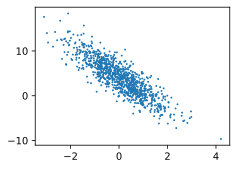

In [22]:
d2l.set_figsize()
# 分离出来变成numpy数组，matplotlib只能接收numpy数组
d2l.plt.scatter(features[:,1].detach().numpy(),labels.detach().numpy(),1)

In [23]:
def data_iter(batch_size, features, labels):
    """ 获取一个batch_size大小的批量 """
    num_examples = len(features)
    # 获得一个从0到num_examples的list数组
    indices = list(range(num_examples))
    # 打乱顺序，随机读取
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i : min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]


batch_size = 10
for X,y in data_iter(batch_size,features,labels):
    print(X,"\n",y)
    break

tensor([[ 0.9119,  0.3734],
        [-0.5569, -0.0215],
        [-0.5988,  1.6703],
        [ 1.2496,  0.5965],
        [ 0.1021, -0.4699],
        [-0.5866,  1.5206],
        [ 0.0662, -0.3387],
        [-1.7043,  2.3616],
        [-0.0910, -0.8977],
        [-0.0795, -1.3290]]) 
 tensor([[ 4.7498],
        [ 3.1522],
        [-2.6844],
        [ 4.6673],
        [ 5.9943],
        [-2.1427],
        [ 5.4932],
        [-7.2218],
        [ 7.0556],
        [ 8.5551]])


In [24]:
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [25]:
def linreg(X, w, b):
    """线性回归模型y = x * w + b"""
    return torch.matmul(X, w) + b


def squared_loss(y_hat, y):
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2


def sgd(params, lr, batch_size):
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            # 减去梯度
            param -= lr * param.grad / batch_size
            param.grad.zero_()

In [26]:
# 学习率
lr = 0.03
num_epochs =  3
net = linreg
loss = squared_loss

In [27]:
# featrues的形状[1,2,1000],X的形状[1,2,batch_size]
for epoch in range(num_epochs):
    for X,y in data_iter(batch_size,features,labels):
        # 求和真实值的方差,l的形状是[batch_size,1]
        l =  loss(net(X,w,b),y)
        # 求导
        l.sum().backward()
        # 沿着最能让loss减小的方向走
        sgd([w,b],lr,batch_size)
    with torch.no_grad():
        # 评估模型和真实值的差距
        train_l =loss(net(features,w,b),labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.040526
epoch 2, loss 0.000154
epoch 3, loss 0.000053


注意，我们不应该想当然地认为我们能够完美地求解参数。
在机器学习中，我们通常不太关心恢复真正的参数，而更关心如何高度准确预测参数。
幸运的是，即使是在复杂的优化问题上，随机梯度下降通常也能找到非常好的解。
其中一个原因是，在深度网络中存在许多参数组合能够实现高度精确的预测。

## 小结

* 我们学习了深度网络是如何实现和优化的。在这一过程中只使用张量和自动微分，不需要定义层或复杂的优化器。
* 这一节只触及到了表面知识。在下面的部分中，我们将基于刚刚介绍的概念描述其他模型，并学习如何更简洁地实现其他模型。

## 练习

1. 如果我们将权重初始化为零，会发生什么。算法仍然有效吗？
1. 假设试图为电压和电流的关系建立一个模型。自动微分可以用来学习模型的参数吗?
1. 能基于[普朗克定律](https://en.wikipedia.org/wiki/Planck%27s_law)使用光谱能量密度来确定物体的温度吗？
1. 计算二阶导数时可能会遇到什么问题？这些问题可以如何解决？
1. 为什么在`squared_loss`函数中需要使用`reshape`函数？
1. 尝试使用不同的学习率，观察损失函数值下降的快慢。
1. 如果样本个数不能被批量大小整除，`data_iter`函数的行为会有什么变化？
